# Pytorch CNN

In [15]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import time

BATCH_SIZE = 128
NUM_EPOCHS = 1

In [16]:
# preprocessing
normalize = transforms.Normalize(mean=[.5], std=[.5])
transform = transforms.Compose([transforms.ToTensor(), normalize])

In [17]:
# download and load the data
train_dataset = torchvision.datasets.MNIST(root='./mnist/', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./mnist/', train=False, transform=transform, download=False)

In [18]:
# encapsulate them into dataloader form
train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [19]:
class Model(nn.Module):
# TODO:define model
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1, 64, 3, 1, 1),#使用了64个3*3的卷积核，步长为1，填充数为1
                                         torch.nn.ReLU(),
                                         torch.nn.Conv2d(64, 128, 3, 1, 1),
                                         torch.nn.ReLU(),
                                         torch.nn.MaxPool2d(2,2))
        self.dense = torch.nn.Sequential(torch.nn.Linear(128 * 14 * 14, 1024),
                                         torch.nn.ReLU(),
                                         torch.nn.Dropout(p = 0.5),
                                         torch.nn.Linear(1024, 10)) # Linear(input, output)上方同理
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 14 * 14 * 128)
        x = self.dense(x)
        return x


In [20]:
model = Model()
print(model)



Model(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=25088, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [25]:
# TODO:define loss function and optimiter

# device = torch.device('cuda')
# model = Model().to(device)

cost = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())

model.load_state_dict(torch.load('model_parameter.pkl'))

<All keys matched successfully>

In [26]:


# train and evaluate
for epoch in range(NUM_EPOCHS):
    sum_loss = 0.0
    train_correct = 0
    for images, labels in tqdm(train_loader):
        # TODO:forward + backward + optimize
        X_train = images
        y_train = labels

        X_train, y_train = torch.autograd.Variable(X_train), torch.autograd.Variable(y_train)
        outputs = model(X_train)
        _, pred = torch.max(outputs.data, 1)

        optimizer.zero_grad()
        loss = cost(outputs, labels)

        loss.backward()
        optimizer.step()
        
        sum_loss += loss.data
        train_correct += torch.sum(pred == y_train.data)
    print('[%d,%d] loss:%.03f' % (epoch + 1, NUM_EPOCHS, sum_loss / len(train_loader)))
    print('correct:%.03f%%' % (100 * train_correct / len(train_dataset)))
torch.save(model.state_dict(), "model_parameter.pkl")        

  

100%|██████████| 468/468 [02:34<00:00,  3.02it/s]


Loss is:0.0004, Train Accuracy is:98.3783%, Test Accuracy is:593.5400


In [33]:
test_correct = 0
for images, labels in tqdm(test_loader): 
# evaluate
# TODO:calculate the accuracy using traning and testing dataset
    X_test = images
    y_test = labels
    X_test, y_test = torch.autograd.Variable(X_test), torch.autograd.Variable(y_test)
    outputs = model(X_test)
    _, pred = torch.max(outputs.data, 1)
    test_correct += torch.sum(pred == y_test.data)
 
print("correct:%.3f%%" % (100 * test_correct / len(test_dataset)))
    

100%|██████████| 78/78 [00:18<00:00,  4.12it/s]

correct:98.500%


In [34]:
print(len(test_dataset))
print(test_correct)
print("correct:%.3f%%" % (100 * test_correct / len(test_dataset)))

10000
tensor(9850)
correct:98.500%


pred: [tensor(8), tensor(9), tensor(4), tensor(3)]
Ture: [tensor(8), tensor(9), tensor(4), tensor(3)]


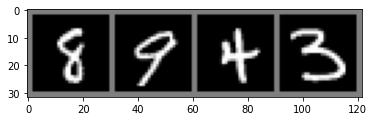

In [45]:
data_loader_test = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size = 4,
                                          shuffle = True)
X_test, y_test = next(iter(data_loader_test))
inputs = torch.autograd.Variable(X_test)
pred = model(inputs)
_, pred = torch.max(pred, 1)

print("pred:",[i for i in pred.data])
print("Ture:",[i for i in y_test])

img = torchvision.utils.make_grid(X_test)
img = img.numpy().transpose(1,2,0)
std = [0.5,0.5,0.5]
mean = [0.5,0.5,0.5]
img = img*std+mean

import matplotlib.pyplot as plt

plt.imshow(img)